## 1. Import Data


In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.layers import Bidirectional, LSTM, GRU, Dense

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.device('/GPU:0')

Defining vector space dimension and fixed input size

In [4]:
# Number of labels
num_classes = 7

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['happiness', 'sadness', 'neutral', 'anger', 'fear', 'surprise', 'disgust']

Importing the dataset to split into training and testing set

In [5]:
data = pd.read_csv('raw_data/emotion_data_merged_4.csv')
data

,sentence,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,happiness
4,i was feeling a little vain when i did this one,sadness
...,...,...
662394,Witnessing the destruction of a natural habita...,disgust
662395,The vulgar display of wealth amidst poverty wa...,disgust
662396,The disregard for personal space and boundarie...,disgust
662397,Their manipulation of others' emotions for per...,disgust


In [6]:
# Assuming 'df' is your DataFrame
# This line drops rows where the 'sentence' column has NaN values
data = data.dropna(subset=['sentence'])

# Now, 'df' will only contain rows where the 'sentence' column is not NaN
data

,sentence,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,happiness
4,i was feeling a little vain when i did this one,sadness
...,...,...
662394,Witnessing the destruction of a natural habita...,disgust
662395,The vulgar display of wealth amidst poverty wa...,disgust
662396,The disregard for personal space and boundarie...,disgust
662397,Their manipulation of others' emotions for per...,disgust


In [7]:
data.value_counts('emotion')

emotion
happiness    190250
neutral      182373
sadness      122251
anger         59703
surprise      55308
fear          44267
disgust        7361
Name: count, dtype: int64

In [8]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

In [9]:
df_train_cleaned = data_train.dropna(subset=['emotion'])

In [10]:
df_test_cleaned = data_test.dropna(subset=['emotion'])

In [11]:
X_train = df_train_cleaned['sentence']
X_test = df_test_cleaned['sentence']
y_train = df_train_cleaned['emotion']
y_test = df_test_cleaned['emotion']

In [12]:

print("\n\nTraining set:", len(X_train))
print("\nTesting set:", len(X_test))



Training set: 529192

Testing set: 132321


<Axes: xlabel='emotion'>

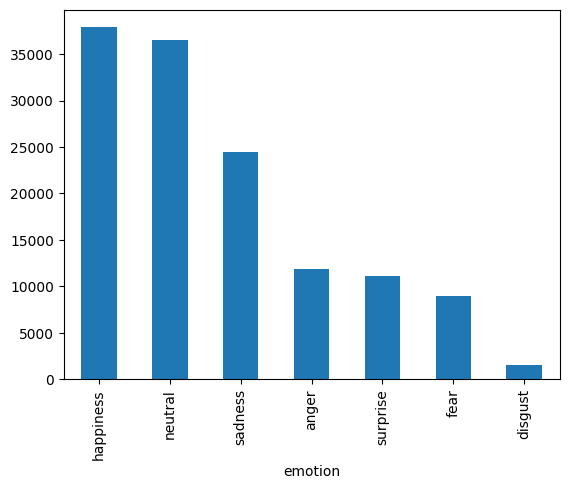

In [13]:
y_test.value_counts().plot(kind='bar')

<Axes: xlabel='emotion'>

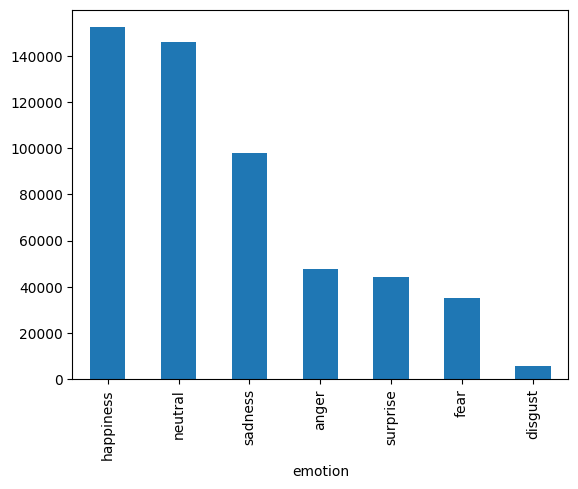

In [14]:
y_train.value_counts().plot(kind='bar')

## 2. Prepare input data

In [15]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

*Making things easier for keras tokenizer 🙃

In [16]:
texts = [' '.join(clean_text(text)) for text in data.sentence]

In [17]:
texts_train = [' '.join(clean_text(text)) for text in X_train]

In [18]:
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [19]:
print(texts_test[74])

i feel like i have to always smile and always talk to someone i just want to not look ecstatic for one second without someone worrying about me


**Tokenization + fitting using keras**

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 90034


In [21]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,  2428,     5, 40773],
       [    0,     0,     0, ...,     2,   266,   567],
       [    0,     0,     0, ...,    31,    24,   524],
       ...,
       [    0,     0,     0, ...,     4,     2,   451],
       [    0,     0,     0, ...,   248,    28,   738],
       [    0,     0,     0, ...,   102,    51,  3632]])

**Categorize** labels: 

In [22]:
encoding = {
    'happiness': 0,
    'sadness': 1,
    'neutral': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5,
    'disgust': 6
}

In [23]:
# Use the map function to transform each emotion to its corresponding integer encoding
y_train_encoded = y_train.map(encoding)

# Or
y_train_array = y_train_encoded.to_numpy()

# y_train_array is now an array of integers representing the emotions according to your encoding
y_train_array

array([3, 5, 0, ..., 0, 0, 1], dtype=int64)

In [24]:
# Use the map function to transform each emotion to its corresponding integer encoding
y_test_encoded = y_test.map(encoding)

# Or
y_test_array = y_test_encoded.to_numpy()

# y_train_array is now an array of integers representing the emotions according to your encoding
y_test_array


array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

In [25]:
# Integer labels
y_train = [encoding[x] for x in df_train_cleaned.emotion]
y_test = [encoding[x] for x in df_test_cleaned.emotion]

In [26]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## 2. Import pretrained word vectors

In [27]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [29]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [30]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(90035, 300)

In [31]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in crawl vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in crawl vocab: 61093
New words found: 28941


## Create LSTM Pipeline

In [32]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming 'embedd_layer' is your pre-defined embedding layer
model = Sequential()
model.add(embedd_layer)  # Your pre-defined embedding layer

# LSTM layer(s)
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(num_classes, activation='softmax')) 


In [34]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          27010500  
                                                                 
 lstm (LSTM)                 (None, 500, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                                 
Total params: 27,280,011
Trainable params: 269,511
Non-t

## Train the Model

In [35]:
X_train_pad.shape, y_train.shape

((529192, 500), (529192, 7))

In [36]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)  # Stop training if validation loss doesn't improve for 3 epochs

In [38]:
batch_size = 128
epochs = 55

# Train the model with early stopping
hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad, y_test),
                 callbacks=[early_stopping])


Epoch 1/55
4135/4135 [==============================] - 499s 119ms/step - loss: 0.3231 - accuracy: 0.8973 - val_loss: 0.2049 - val_accuracy: 0.9362
Epoch 2/55
4135/4135 [==============================] - 510s 123ms/step - loss: 0.1969 - accuracy: 0.9379 - val_loss: 0.1831 - val_accuracy: 0.9406
Epoch 3/55
4135/4135 [==============================] - 479s 116ms/step - loss: 0.1789 - accuracy: 0.9426 - val_loss: 0.1789 - val_accuracy: 0.9417
Epoch 4/55
4135/4135 [==============================] - 497s 120ms/step - loss: 0.1692 - accuracy: 0.9449 - val_loss: 0.1684 - val_accuracy: 0.9445
Epoch 5/55
4135/4135 [==============================] - 476s 115ms/step - loss: 0.1611 - accuracy: 0.9470 - val_loss: 0.1709 - val_accuracy: 0.9444
Epoch 6/55
4135/4135 [==============================] - 485s 117ms/step - loss: 0.2202 - accuracy: 0.9276 - val_loss: 0.2492 - val_accuracy: 0.9213
Epoch 7/55
4135/4135 [==============================] - 481s 116ms/step - loss: 0.1676 - accuracy: 0.9452 - val_

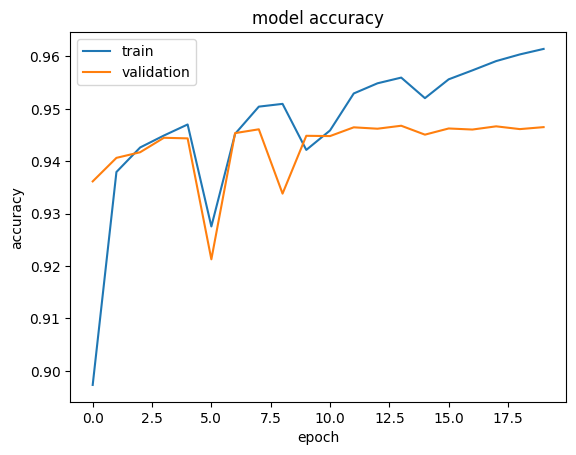

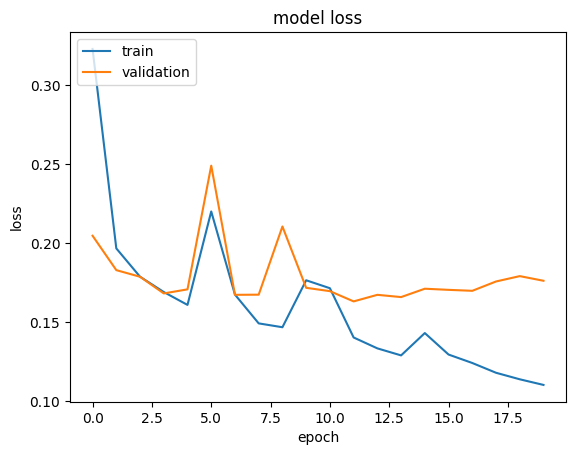

In [39]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluation

In [40]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

4136/4136 [==============================] - 143s 34ms/step


In [41]:
print("Accuracy: {:.2f}%".format(accuracy_score(df_test_cleaned.emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df_test_cleaned.emotion, predictions, average='micro') * 100))

Accuracy: 94.65%

F1 Score: 94.65


#### Plotting confusion Matrix:

In [42]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 94.65


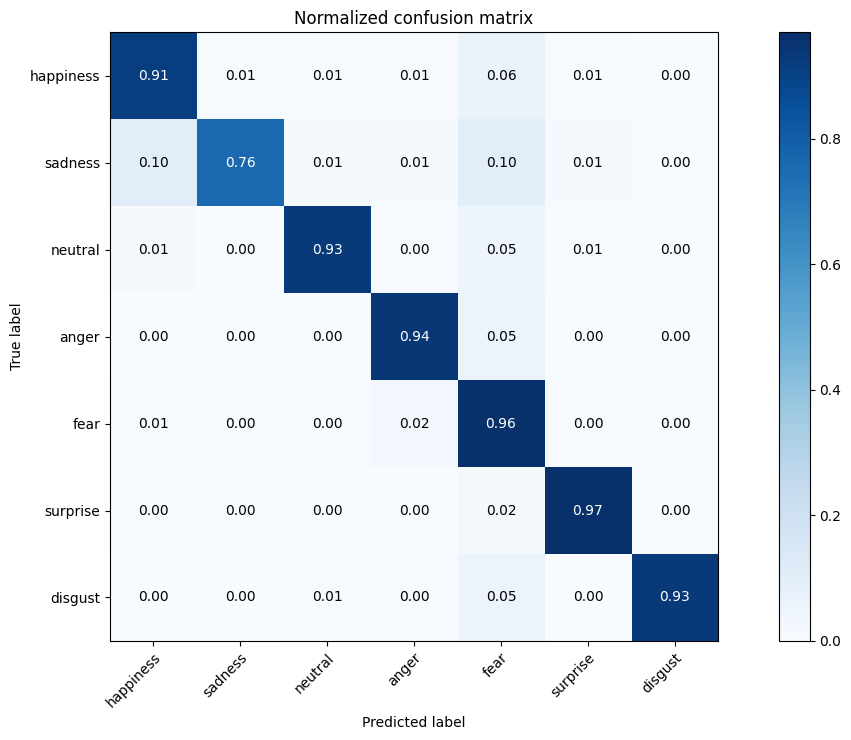

In [43]:
print("\nF1 Score: {:.2f}".format(f1_score(df_test_cleaned.emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(df_test_cleaned.emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [44]:
import time

message = ['I am so sad at you!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 31ms/step
Message: ['I am so sad at you!']
predicted: sadness (0.11 seconds)


In [45]:
kaggle_data = pd.read_csv('raw_data/kaggle_data.csv', sep='\t')
kaggle_data

,id,sentence
0,0,Girls are happy when they get flowers
1,1,His jaw dropped in disbelief when he saw the p...
2,2,Sometimes the ugly stench makes me wanna throw...
3,3,The foul odor from the garbage bin was disgust...
4,4,"I can’t believe it, they lost the game in the ..."
...,...,...
1431,1431,I feel guilty about the ice cream I stole as a...
1432,1432,Her ability to recall obscure facts never ceas...
1433,1433,"Your cat is so cute, I love him."
1434,1434,She remained skeptical about the new product.


In [46]:
# Function to predict emotion for a given sentence
def predict_emotion(sentence):
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=max_seq_len)
    pred = model.predict(padded, verbose = 0)
    return class_names[np.argmax(pred)]

In [47]:
# Apply predict_emotion function to each sentence in the DataFrame
kaggle_data['emotion'] = kaggle_data['sentence'].apply(predict_emotion)

In [48]:
kaggle_data.value_counts('emotion')

emotion
neutral      312
anger        234
happiness    226
fear         202
sadness      198
surprise     133
disgust      131
Name: count, dtype: int64

In [49]:
kaggle_data

,id,sentence,emotion
0,0,Girls are happy when they get flowers,neutral
1,1,His jaw dropped in disbelief when he saw the p...,surprise
2,2,Sometimes the ugly stench makes me wanna throw...,disgust
3,3,The foul odor from the garbage bin was disgust...,disgust
4,4,"I can’t believe it, they lost the game in the ...",neutral
...,...,...,...
1431,1431,I feel guilty about the ice cream I stole as a...,sadness
1432,1432,Her ability to recall obscure facts never ceas...,surprise
1433,1433,"Your cat is so cute, I love him.",happiness
1434,1434,She remained skeptical about the new product.,neutral


In [50]:
# Creating new dataframe without the sentence column:
kaggle_submission = kaggle_data.drop('sentence', axis=1)

In [53]:
kaggle_submission.value_counts('emotion')

emotion
neutral      312
anger        234
happiness    226
fear         202
sadness      198
surprise     133
disgust      131
Name: count, dtype: int64

In [51]:
kaggle_submission.to_csv('submission_1_LSTM.csv', index=False)

In [52]:
# creates a HDF5 file 'my_model.h5'
model.save('models/LSTM_w2v_1.h5')